# はじめに

# LangGraph4j 詳細解説

## 1. LangGraphの基本概念

LangGraphは、言語モデル（LLM）を活用した複雑なアプリケーションを構築するためのフレームワークです。LangGraph4jはJava言語用の実装であり、Python版のLangChain/LangGraphと同様の設計思想に基づいています。

### LangGraph4jとは

- **定義**: LangGraph4jは、グラフベースのアーキテクチャで複雑なAIワークフローを構築するためのJavaライブラリです
- **目的**: LLMを使ったアプリケーションをモジュール化し、管理しやすいコンポーネントに分解すること
- **主な特徴**: 状態管理、グラフベースの実行フロー、型安全性

### グラフベース設計のメリット

- **モジュール性**: 機能を独立したノードとして実装でき、再利用性が高まります
- **可視性**: アプリケーションのフローを視覚的に表現でき、複雑な処理も理解しやすくなります
- **拡張性**: 新しい機能を既存のグラフに簡単に追加できます
- **デバッグ**: 各ノードの実行と状態変化を追跡しやすくなります

## 2. LangGraph4jのコアコンポーネント

### StateGraph

StateGraphはLangGraph4jの中心的なクラスで、グラフの構造と実行フローを定義します。

- **初期化**: 状態の型とスキーマを指定して初期化
- **コンパイル**: グラフが実行可能かを検証し、実行エンジンに変換
- **実行**: 初期状態を与えて実行し、状態の変化をストリームとして取得

### ノードとエッジ

- **ノード**: 処理を実行する関数やクラス（`NodeAction`インターフェースを実装）
- **エッジ**: ノード間の接続関係と実行順序を定義
- **特殊ノード**: `START`と`END`という特殊なノードがあり、グラフの開始と終了を表す

### 状態管理

- **AgentState**: グラフの実行中にデータを保持・更新するためのクラス
- **Channel**: 状態の更新方法を定義（置換、追加、マージなど）
- **スキーマ**: 状態の構造を定義し、型安全性を確保

In [2]:
var userHomeDir = System.getProperty("user.home");
var localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
var langchain4jVersion = "1.0.1";
var langchain4jbeta = "1.0.1-beta6";
var langgraph4jVersion = "1.6.0-beta2";

Jupyterキャッシュからインストールされたパッケージを削除

In [3]:
%%bash 
rm -rf \{userHomeDir}/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j

ローカルMavenリポジトリを追加し、必要なMaven依存関係をインストール

In [4]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.slf4j:slf4j-jdk14:2.0.9
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.8
%dependency /resolve

Repository local url: file:///Users/koheisaito/.m2/repository/ added.
Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.6.0-beta2
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Adding dependency org.slf4j:slf4j-jdk14:2.0.9
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.6.0-beta2
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.8
Solving dependencies
Resolved artifacts count: 5
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-jdk14/2.0.9/slf4j-jdk14-2.0.9.jar
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/slf4j/slf4j-api/2.0.9/slf4j-api-2.0.9.jar
Add to classpath: /Users/koheisaito/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core/1.6.0-beta2/langgraph4j-core-1.6.0-beta2.jar
Add to classpath: /Users/koheisaito/Library/Jup

In [5]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;
import org.bsc.langgraph4j.GraphRepresentation;

void displayDiagram( GraphRepresentation representation ) throws IOException { 
    
    var reader = new SourceStringReader(representation.getContent());

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        var image = javax.imageio.ImageIO.read( imageInStream );

        display(  image );

    }
}

### 2-1. Stateの定義

- State: **メッセージのリストを保持**します。

In [6]:
import org.bsc.langgraph4j.state.AgentState;
import org.bsc.langgraph4j.state.Channels;
import org.bsc.langgraph4j.state.Channel;

import java.util.Collections;
import java.util.List;
import java.util.Map;
import java.util.Optional;

// Define the state for our graph
class SimpleState extends AgentState {
    public static final String MESSAGES_KEY = "messages";

    // Define the schema for the state.
    // MESSAGES_KEY will hold a list of strings, and new messages will be appended.
    public static final Map<String, Channel<?>> SCHEMA = Map.of(
            MESSAGES_KEY, Channels.appender(ArrayList::new)
    );

    public SimpleState(Map<String, Object> initData) {
        super(initData);
    }

    public List<String> messages() {
        return this.<List<String>>value("messages")
                .orElse( List.of() );
    }
}

### 2-2. ノードの定義

In [10]:
import org.bsc.langgraph4j.action.NodeAction;
import java.util.Collections;
import java.util.Map;

// Node that adds a greeting
class GreeterNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("GreeterNode executing. Current messages: " + state.messages());
        return Map.of(SimpleState.MESSAGES_KEY, "Hello from GreeterNode!");
    }
}

// Node that adds a response
class ResponderNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("ResponderNode executing. Current messages: " + state.messages());
        List<String> currentMessages = state.messages();
        if (currentMessages.contains("Hello from GreeterNode!")) {
            return Map.of(SimpleState.MESSAGES_KEY, "Acknowledged greeting!");
        }
        return Map.of(SimpleState.MESSAGES_KEY, "No greeting found.");
    }
}

### 2-3. グラフの定義とコンパイル

In [ ]:
import org.bsc.langgraph4j.StateGraph;
import org.bsc.langgraph4j.GraphStateException;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.StateGraph.START;
import static org.bsc.langgraph4j.StateGraph.END;

import java.util.List;
import java.util.Map;
import java.io.IOException;

public class SimpleGraphApp {
    
    public static void main(String[] args) throws GraphStateException, IOException {
        // Initialize nodes
        GreeterNode greeterNode = new GreeterNode();
        ResponderNode responderNode = new ResponderNode();

        // Define the graph structure
       var stateGraph = new StateGraph<>(SimpleState.SCHEMA, initData -> new SimpleState(initData))
            .addNode("greeter", node_async(greeterNode))
            .addNode("responder", node_async(responderNode))
            // Define edges
            .addEdge(START, "greeter") // Start with the greeter node
            .addEdge("greeter", "responder")
            .addEdge("responder", END)   // End after the responder node
            ;
        // Compile the graph
        var compiledGraph = stateGraph.compile();

        // Run the graph
        // The `stream` method returns an AsyncGenerator.
        // For simplicity, we'll collect results. In a real app, you might process them as they arrive.
        // Here, the final state after execution is the item of interest.
        
        for (var item : compiledGraph.stream( Map.of( SimpleState.MESSAGES_KEY, "Let's, begin!" ) ) ) {
            System.out.println( item );
        }

        var representation = stateGraph.getGraph( GraphRepresentation.Type.PLANTUML, "Graph", false );
        try {
            // Display the diagram
            displayDiagram(representation);
        } catch (IOException e) {
            System.err.println("Error displaying diagram: " + e.getMessage());
        }
    }
}



GreeterNode executing. Current messages: [Let's, begin!]
NodeOutput{node=__START__, state={messages=[Let's, begin!]}}
ResponderNode executing. Current messages: [Let's, begin!, Hello from GreeterNode!]
NodeOutput{node=greeter, state={messages=[Let's, begin!, Hello from GreeterNode!]}}
NodeOutput{node=responder, state={messages=[Let's, begin!, Hello from GreeterNode!, Acknowledged greeting!]}}
NodeOutput{node=__END__, state={messages=[Let's, begin!, Hello from GreeterNode!, Acknowledged greeting!]}}
NodeOutput{node=__START__, state={messages=[Let's, begin!]}}
ResponderNode executing. Current messages: [Let's, begin!, Hello from GreeterNode!]
NodeOutput{node=greeter, state={messages=[Let's, begin!, Hello from GreeterNode!]}}
NodeOutput{node=responder, state={messages=[Let's, begin!, Hello from GreeterNode!, Acknowledged greeting!]}}
NodeOutput{node=__END__, state={messages=[Let's, begin!, Hello from GreeterNode!, Acknowledged greeting!]}}


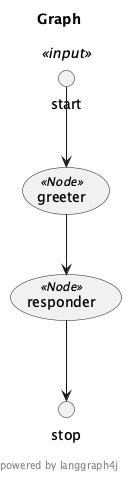

: 

In [ ]:
SimpleGraphApp.main(new String[]{});

## 3. 高度なグラフ機能

### 条件分岐

LangGraph4jでは、条件に基づいて次のノードを動的に決定することができます。これによって、複雑な意思決定フローを実装できます。

- **条件付きエッジ**: 条件関数を定義して、次に実行するノードを動的に決定
- **マルチパス**: 複数の可能なパスから条件に基づいて選択

### ループと再帰パターン

反復処理や再帰的な処理フローも実装できます。

- **セルフエッジ**: ノードから自分自身へのエッジを作成してループを実現
- **条件付き終了**: 特定の条件が満たされるまでループを継続

In [ ]:
import org.bsc.langgraph4j.edge.EdgeCondition;
import java.util.function.Function;

// 条件分岐を持つグラフの例
public class ConditionalGraphExample {
    
    public static void main(String[] args) throws GraphStateException, IOException {
        // 条件関数の定義
        Function<SimpleState, String> routingFunction = state -> {
            List<String> messages = state.messages();
            if (messages.stream().anyMatch(msg -> msg.contains("error"))) {
                return "error_handler"; // エラーが検出されたらエラーハンドラへ
            } else {
                return "success_handler"; // それ以外は成功ハンドラへ
            }
        };
        
        // グラフの構築
        var stateGraph = new StateGraph<>(SimpleState.SCHEMA, initData -> new SimpleState(initData))
            .addNode("router", node_async(new RouterNode()))
            .addNode("error_handler", node_async(new ErrorHandlerNode()))
            .addNode("success_handler", node_async(new SuccessHandlerNode()))
            
            // エッジの定義
            .addEdge(START, "router")
            .addConditionalEdges("router", routingFunction) // 条件に基づいてエッジを選択
            .addEdge("error_handler", END)
            .addEdge("success_handler", END);
        
        var compiledGraph = stateGraph.compile();
        
        // グラフの実行と可視化
        var representation = stateGraph.getGraph(GraphRepresentation.Type.PLANTUML, "Conditional Graph", false);
        displayDiagram(representation);
    }
}

// ルーティングノード
class RouterNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("RouterNode executing. Deciding next step...");
        // 何らかの処理を行い、メッセージを追加
        if (Math.random() > 0.5) {
            return Map.of(SimpleState.MESSAGES_KEY, "error detected");
        } else {
            return Map.of(SimpleState.MESSAGES_KEY, "processing successful");
        }
    }
}

// エラーハンドラノード
class ErrorHandlerNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("ErrorHandlerNode executing. Handling error...");
        return Map.of(SimpleState.MESSAGES_KEY, "Error has been handled");
    }
}

// 成功ハンドラノード
class SuccessHandlerNode implements NodeAction<SimpleState> {
    @Override
    public Map<String, Object> apply(SimpleState state) {
        System.out.println("SuccessHandlerNode executing. Processing success...");
        return Map.of(SimpleState.MESSAGES_KEY, "Success has been processed");
    }
}

## 4. LLMとの統合

LangGraph4jは、LLM（大規模言語モデル）を活用したアプリケーションの構築に特に強みを発揮します。以下は、LLMをグラフに統合する主な方法です。

### LLMノードの実装

LLMをノードとして実装することで、自然言語処理の機能をグラフのワークフローに組み込むことができます。

- **プロンプトの構築**: 前のノードの結果を使用して動的なプロンプトを構築
- **出力の解析**: LLMの出力を構造化して次のノードで使用しやすい形に変換
- **エラー処理**: LLMの応答が期待通りでない場合のリトライや代替処理

### 並列処理と非同期実行

複数のLLM呼び出しを効率的に処理するための仕組み:

- **非同期ノード**: 時間のかかるLLM呼び出しを非同期で実行
- **並列実行**: 互いに依存しないノードを並列に実行してレスポンスタイムを短縮

In [ ]:
import java.util.concurrent.CompletableFuture;
import org.bsc.langgraph4j.action.AsyncNodeAction;

// LLMを呼び出す非同期ノードの例
class LLMNode implements AsyncNodeAction<SimpleState> {
    @Override
    public CompletableFuture<Map<String, Object>> apply(SimpleState state) {
        return CompletableFuture.supplyAsync(() -> {
            // ここでLLM APIを呼び出す（例: OpenAI APIなど）
            System.out.println("Calling LLM API...");
            
            // APIコールのシミュレーション
            try {
                Thread.sleep(1000); // LLM呼び出しの遅延をシミュレート
            } catch (InterruptedException e) {
                Thread.currentThread().interrupt();
            }
            
            // LLMからの応答をシミュレート
            String llmResponse = "This is a simulated response from the LLM API";
            
            // 状態を更新して返却
            return Map.of(SimpleState.MESSAGES_KEY, llmResponse);
        });
    }
}

## 5. 実践的なユースケース

LangGraph4jは様々なアプリケーションで活用できますが、特に以下のようなユースケースに適しています。

### マルチエージェントシステム

複数のAIエージェントが協調して問題を解決するシステム:

- **役割分担**: 各エージェントが特定の役割や専門知識を持つ
- **協調作業**: エージェント間でのデータ共有と協調的な意思決定
- **監督機構**: エージェントの出力を統合し監督するコントローラ

### 会話型AIアプリケーション

複雑な会話フローを管理するシステム:

- **コンテキスト管理**: 会話の履歴と状態を保持
- **インテント理解**: ユーザーの意図を理解して適切なノードにルーティング
- **知識グラフ統合**: 外部知識ソースとの連携

### ワークフロー自動化

複雑なビジネスプロセスを自動化:

- **ドキュメント処理**: 契約書や申請書などのドキュメント処理の自動化
- **意思決定支援**: データに基づいた意思決定のサポート
- **マルチステップ処理**: 複数のステップからなるプロセスの統合管理

In [ ]:
// マルチエージェントシステムの簡易実装例
public class MultiAgentExample {
    
    public static void main(String[] args) throws GraphStateException, IOException {
        // 各エージェントノードの初期化
        var researchAgent = new ResearchAgentNode();
        var summaryAgent = new SummaryAgentNode();
        var criticalThinkingAgent = new CriticalThinkingAgentNode();
        var coordinatorAgent = new CoordinatorAgentNode();
        
        // グラフの構築
        var stateGraph = new StateGraph<>(ComplexState.SCHEMA, initData -> new ComplexState(initData))
            .addNode("coordinator", node_async(coordinatorAgent))
            .addNode("research", node_async(researchAgent))
            .addNode("summary", node_async(summaryAgent))
            .addNode("critical_thinking", node_async(criticalThinkingAgent))
            
            // 基本フロー
            .addEdge(START, "coordinator")
            .addEdge("coordinator", "research")
            .addEdge("research", "summary")
            .addEdge("summary", "critical_thinking")
            .addEdge("critical_thinking", "coordinator")
            
            // 条件付きエッジ（完了条件）
            .addConditionalEdges("coordinator", state -> {
                // メタデータから完了フラグを確認
                var metadata = state.metadata();
                if (metadata.containsKey("completed") && (Boolean)metadata.get("completed")) {
                    return END;
                }
                return "research"; // 完了していなければ処理を継続
            });
        
        var compiledGraph = stateGraph.compile();
        
        // グラフの可視化
        var representation = stateGraph.getGraph(GraphRepresentation.Type.PLANTUML, "Multi-Agent System", false);
        displayDiagram(representation);
    }
}

// エージェントノード実装例（簡略化）
class ResearchAgentNode implements AsyncNodeAction<ComplexState> {
    @Override
    public CompletableFuture<Map<String, Object>> apply(ComplexState state) {
        return CompletableFuture.supplyAsync(() -> {
            System.out.println("ResearchAgent: Gathering information...");
            return Map.of(
                ComplexState.MESSAGES_KEY, "Research completed: Found relevant information",
                ComplexState.CONTEXT_KEY, "Information context from research"
            );
        });
    }
}

class SummaryAgentNode implements AsyncNodeAction<ComplexState> {
    @Override
    public CompletableFuture<Map<String, Object>> apply(ComplexState state) {
        return CompletableFuture.supplyAsync(() -> {
            System.out.println("SummaryAgent: Summarizing information...");
            return Map.of(
                ComplexState.MESSAGES_KEY, "Summary created based on research",
                ComplexState.METADATA_KEY, Map.of("summary_created", true)
            );
        });
    }
}

class CriticalThinkingAgentNode implements AsyncNodeAction<ComplexState> {
    @Override
    public CompletableFuture<Map<String, Object>> apply(ComplexState state) {
        return CompletableFuture.supplyAsync(() -> {
            System.out.println("CriticalThinkingAgent: Analyzing summary...");
            return Map.of(
                ComplexState.MESSAGES_KEY, "Critical analysis complete",
                ComplexState.METADATA_KEY, Map.of("analysis_complete", true)
            );
        });
    }
}

class CoordinatorAgentNode implements AsyncNodeAction<ComplexState> {
    @Override
    public CompletableFuture<Map<String, Object>> apply(ComplexState state) {
        return CompletableFuture.supplyAsync(() -> {
            System.out.println("CoordinatorAgent: Evaluating progress...");
            
            // 進行状況を評価して完了かどうか判断
            var metadata = state.metadata();
            boolean summaryCreated = metadata.containsKey("summary_created");
            boolean analysisComplete = metadata.containsKey("analysis_complete");
            
            if (summaryCreated && analysisComplete) {
                System.out.println("CoordinatorAgent: Work completed, finalizing...");
                return Map.of(
                    ComplexState.MESSAGES_KEY, "Task completed successfully",
                    ComplexState.METADATA_KEY, Map.of("completed", true)
                );
            } else {
                return Map.of(
                    ComplexState.MESSAGES_KEY, "Continuing the process",
                    ComplexState.METADATA_KEY, Map.of("iteration", metadata.getOrDefault("iteration", 0))
                );
            }
        });
    }
}

## 6. デバッグとモニタリング

複雑なLLMアプリケーションを開発する際、デバッグとモニタリングは重要な要素です。LangGraph4jはこれらの機能をサポートしています。

### グラフの可視化

- **PlantUML**: グラフの構造を視覚的に表示
- **GraphViz**: 代替のグラフ可視化形式
- **実行パス追跡**: 実行されたノードとエッジのハイライト表示

### ログと状態追跡

- **詳細ログ**: 各ノードの実行開始・終了・エラーをログ記録
- **状態スナップショット**: 各ステップでの状態を確認
- **トレースバック**: エラー発生時の状態とコールスタックの表示

### パフォーマンスモニタリング

- **実行時間測定**: 各ノードとグラフ全体の実行時間測定
- **リソース使用量**: メモリ使用量やAPI呼び出し数の追跡
- **ボトルネック特定**: パフォーマンスの問題点を特定

In [ ]:
import org.slf4j.Logger;
import org.slf4j.LoggerFactory;
import java.time.Duration;
import java.time.Instant;

// デバッグとモニタリング機能を持ったノード
class MonitoredNode implements NodeAction<SimpleState> {
    private static final Logger logger = LoggerFactory.getLogger(MonitoredNode.class);
    private final String nodeName;
    
    public MonitoredNode(String nodeName) {
        this.nodeName = nodeName;
    }
    
    @Override
    public Map<String, Object> apply(SimpleState state) {
        logger.info("{} - Starting execution", nodeName);
        Instant start = Instant.now();
        
        try {
            // ノードの実際の処理
            logger.info("{} - Processing state: {}", nodeName, state);
            
            // 処理をシミュレート
            Thread.sleep(500);
            
            // 結果を返却
            var result = Map.of(SimpleState.MESSAGES_KEY, "Processed by " + nodeName);
            logger.info("{} - Completed successfully", nodeName);
            return result;
            
        } catch (Exception e) {
            logger.error("{} - Execution error: {}", nodeName, e.getMessage(), e);
            throw new RuntimeException("Error in node: " + nodeName, e);
        } finally {
            Duration elapsed = Duration.between(start, Instant.now());
            logger.info("{} - Execution took {} ms", nodeName, elapsed.toMillis());
        }
    }
}

## 7. ベストプラクティスとパターン

LangGraph4jを効果的に活用するためのベストプラクティスとデザインパターンをいくつか紹介します。

### 状態設計のパターン

- **イミュータブルデータ**: 状態更新を明示的に行い、予期せぬ変更を防止
- **階層的状態**: 関連する情報をグループ化して状態を整理
- **型安全性**: カスタムクラスとアクセサメソッドによる型安全な状態アクセス

### エラー処理と回復性

- **グレースフル・デグラデーション**: エラー発生時でも部分的な機能を維持
- **リトライ・メカニズム**: 一時的な障害からの回復
- **フォールバック戦略**: 代替手段による処理継続

### スケーラビリティ

- **ステートレス設計**: ノードをステートレスに設計し、スケールアウトを容易に
- **バッチ処理**: 効率的なバッチ処理によるスループット向上
- **キャッシング**: 頻繁に使用される結果のキャッシングによるパフォーマンス改善

In [ ]:
// エラー処理とリカバリーのパターンを実装したノード
class ResilientLLMNode implements AsyncNodeAction<SimpleState> {
    private static final Logger logger = LoggerFactory.getLogger(ResilientLLMNode.class);
    private static final int MAX_RETRIES = 3;
    
    @Override
    public CompletableFuture<Map<String, Object>> apply(SimpleState state) {
        return CompletableFuture.supplyAsync(() -> {
            int attempts = 0;
            Exception lastException = null;
            
            while (attempts < MAX_RETRIES) {
                attempts++;
                try {
                    logger.info("LLM API call attempt {} of {}", attempts, MAX_RETRIES);
                    
                    // ここでLLMのAPI呼び出し（失敗する可能性あり）
                    if (Math.random() < 0.5 && attempts < MAX_RETRIES) {
                        // シミュレートされたエラー
                        throw new RuntimeException("Simulated LLM API error");
                    }
                    
                    // 成功した場合
                    logger.info("LLM API call successful on attempt {}", attempts);
                    return Map.of(SimpleState.MESSAGES_KEY, "LLM response after " + attempts + " attempts");
                    
                } catch (Exception e) {
                    lastException = e;
                    logger.warn("LLM API call failed on attempt {}: {}", attempts, e.getMessage());
                    
                    // エクスポネンシャルバックオフ
                    try {
                        Thread.sleep((long) Math.pow(2, attempts) * 100);
                    } catch (InterruptedException ie) {
                        Thread.currentThread().interrupt();
                        throw new RuntimeException("Interrupted during retry delay", ie);
                    }
                }
            }
            
            // 全てのリトライが失敗した場合はフォールバック
            logger.error("All {} LLM API attempts failed", MAX_RETRIES);
            return Map.of(
                SimpleState.MESSAGES_KEY, "Unable to get LLM response after " + MAX_RETRIES + " attempts. Using fallback.",
                "error", lastException != null ? lastException.getMessage() : "Unknown error"
            );
        });
    }
}

## 8. まとめと次のステップ

### LangGraph4jの利点

- **モジュール性**: 複雑なAIアプリケーションをモジュール化して管理しやすくする
- **可視化**: アプリケーションのフローを視覚的に理解できる
- **拡張性**: 新しい機能やコンポーネントを柔軟に追加できる
- **型安全性**: Javaの型システムを活かした安全な実装

### 次のステップ

- **複雑なユースケース**: より複雑なユースケースへの適用
- **外部システム連携**: データベースやAPIとの連携
- **デプロイメント**: 本番環境へのデプロイと運用
- **高度なLLM統合**: より洗練されたLLMとの対話パターンの実装

### 参考リソース

- LangGraph4j GitHub: https://github.com/langchain4j/langchain4j-examples
- LangChain: https://www.langchain.com/
- Java非同期プログラミング: https://docs.oracle.com/javase/tutorial/essential/concurrency/